# Greta complete Scenic+ workflow
This notebook goes with its corresponding markdown file, with the same name.

`./runi dts/hg38/pbmc10k/cases/all/runs/o_scenicplus.o_scenicplus.o_scenicplus.o_scenicplus.mdl.csv`

to regenerate the DAG : `snakemake dts/hg38/pbmc10k/cases/all/runs/o_scenicplus.o_scenicplus.o_scenicplus.o_scenicplus.mdl.csv --dag | dot -Tsvg > dag.svg` 

In [81]:
import numpy as np
import pandas as pd
import os
import pyarrow.feather as feather
import pyarrow as pa
import scanpy as sc
import muon as mu
import scipy.io
import h5py

Here are the jobs triggered by the rules : 
```bash
job                      count
---------------------  -------
annotate_pbmc10k             1
callpeaks_pbmc10k            1
cre_blacklist                1
dwn_image                    2
extract_case                 1
gen_genome_scenicplus        1
gen_gid_ensmbl               1
gen_motif_scenicplus         1
mdl_o_scenicplus             1
prcannot_pbmc10k             1
total                       11
``` 

## 1. Inputs 

In [2]:
dir = "/globalscratch/vangysel/greta"

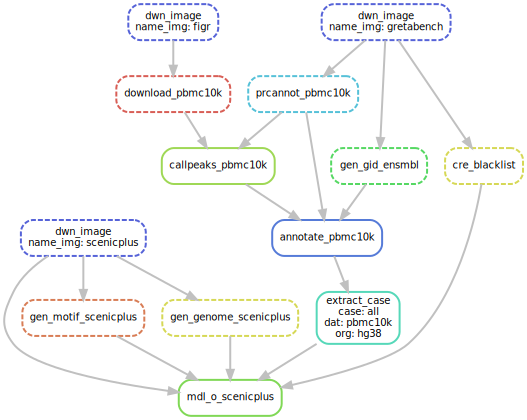

In [3]:
from IPython.display import SVG, display
display(SVG(filename=f"{dir}/notes_scenic+/dag.svg"))

We will go through each layer of the DAG (top layer is the `dwn_image` and last layer is `mdl_o_scenicplus`)

### Layer 1 
Download `figr.sif` & `gretabench.sif` the images used to run the further steps.


### Layer 2 

-  `download_pbmc10k` : download the pbmc10k dataset (get ATAC files, RNA are downloaded sperately and cached)
    - `dts/hg38/pbmc10k/smpl.frags.tsv.gz`
    - `dts/hg38/pbmc10k/smpl.frags.tsv.gz.tbi`
<br><br>
      
- `prcannot_pbmc10k` : cell annotation (metadata)

In [4]:
frags = pd.read_csv(
    f"{dir}/dts/hg38/pbmc10k/smpl.frags.tsv.gz",
    sep="\t",
    nrows=100000,   # do not load the entire file
    header=None,
    names=["chr", "start", "end", "barcode", "count"]
)

In [5]:
frags.head(3)

,chr,start,end,barcode,count
0,chr1,10066,10478,smpl_TCAAGAACAGTAATAG,1
1,chr1,10072,10191,smpl_AACCCGCAGGTAGCTT,1
2,chr1,10073,10340,smpl_CGCATATAGGTTACGT,2


In [25]:
pbmc_annot = pd.read_csv(f"{dir}/dts/hg38/pbmc10k/annot.csv")

In [27]:
pbmc_annot.head(3)

,Unnamed: 0,batch,celltype
0,smpl_AAACAGCCAATCCCTT,smpl,CD4 TCM
1,smpl_AAACAGCCAATGCGCT,smpl,CD4 Naive
2,smpl_AAACAGCCACCAACCG,smpl,CD8 Naive


### Layer 3
- `gen_gid_ensmbl` : gene id symbol mapping

In [44]:
ens_human = pd.read_csv(f"{dir}/dbs/hg38/gen/gid/ensembl.csv")
ens_mouse = pd.read_csv(f"{dir}/dbs/mm10/gen/gid/ensembl.csv")

In [45]:
ens_human.head(3)

,id,symbol
0,ENSG00000210049,MT-TF
1,ENSG00000211459,MT-RNR1
2,ENSG00000210077,MT-TV


- `cre_blacklist` : regions to ignore

In [42]:
blacklist = pd.read_csv(
    f"{dir}/dbs/hg38/cre/blacklist/blacklist.bed.gz",
    sep="\t",
    header=None,
    names=["start", "end", "reason"]
)

In [43]:
blacklist.head(3)

,start,end,reason
chr10,0,45700,Low Mappability
chr10,38481300,38596500,High Signal Region
chr10,38782600,38967900,High Signal Region


- `callpeaks_pbmc10k`

In [9]:
peaks = sc.read_h5ad(f"{dir}/dts/hg38/pbmc10k/peaks.h5ad")
peaks

AnnData object with n_obs × n_vars = 9631 × 215676

In [12]:
peaks.obs.head(3)

""
smpl_AAACAGCCAATCCCTT
smpl_AAACAGCCAATGCGCT
smpl_AAACAGCCACCAACCG


In [11]:
peaks.var.head(3)

""
chr1-9947-10447
chr1-96340-96840
chr1-180660-181160


### Layer 4 
- `annotate_pbmc10k`

In [ ]:
# assembles the raw multimodal object <annotated.h5mu>

In [30]:
annotated = mu.read(f"{dir}/dts/hg38/pbmc10k/annotated.h5mu")
annotated

/home/ucl/inma/vangysel/.local/lib/python3.11/site-packages/mudata/_core/mudata.py:1403: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/ucl/inma/vangysel/.local/lib/python3.11/site-packages/mudata/_core/mudata.py:1275: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 9631 × 233968
  obs:	'batch', 'celltype'
  2 modalities
    rna:	9631 x 18292
    atac:	9631 x 215676

In [17]:
annotated['rna']

AnnData object with n_obs × n_vars = 9631 × 18292

In [24]:
annotated['rna'].obs.head(3)

""
smpl_AAACAGCCAATCCCTT
smpl_AAACAGCCAATGCGCT
smpl_AAACAGCCACCAACCG


In [25]:
annotated['rna'].var.head(3)

""
LINC01409
FAM87B
LINC01128


In [21]:
annotated['atac']

AnnData object with n_obs × n_vars = 9631 × 215676

In [27]:
annotated['atac'].obs.head(3)

""
smpl_AAACAGCCAATCCCTT
smpl_AAACAGCCAATGCGCT
smpl_AAACAGCCACCAACCG


In [31]:
annotated['atac'].var.head(3)

""
chr1-9947-10447
chr1-96340-96840
chr1-180660-181160


### Layer 5

The PBMC10k dataset is now ready (`.h5mu` file), we can run `mdl_o_scenicplus`.  <br><br>
It needs the following inputs : <br>
2) `blist` : cre blacklist (already download in Layer 3 : `cre_blacklist`)

#### 5.1 From `gen_motif_scenicplus`


3) `rnk`: regions_vs_motifs.rankings

In [72]:
path = f"{dir}/dbs/hg38/gen/motif/scenicplus/human_motif_SCREEN.regions_vs_motifs.rankings.feather"

source = pa.memory_map(path, 'r')
reader = pa.ipc.open_file(source)
schema = reader.schema

In [80]:
print("First 5 cols:", schema.names[:5])
print("Last 5 cols:", schema.names[-5:])
print("Motifs col type:", schema.field('motifs').type)
print("Metadata:", schema.metadata)

First 5 cols: ['chr10:100000176-100000504', 'chr10:100001759-100001930', 'chr10:100004841-100005148', 'chr10:100005876-100006219', 'chr10:100006302-100006644']
Last 5 cols: ['chrY:9924284-9924623', 'chrY:9954840-9955041', 'chrY:9959132-9959359', 'chrY:9997981-9998328', 'motifs']
Motifs col type: string
Metadata: None


4) `man` : motif annotations


In [58]:
man_sample = pd.read_csv(
    f"{dir}/dbs/hg38/gen/motif/scenicplus/motifs-v10nr_clust/nr.hgnc-m0.001-o0.0.tbl",
    sep="\t",
    nrows=10000 
)

In [60]:
man_sample.head(3)

,#motif_id,motif_name,motif_description,source_name,source_version,gene_name,motif_similarity_qvalue,similar_motif_id,similar_motif_description,orthologous_identity,orthologous_gene_name,orthologous_species,description
0,metacluster_196.3,EcR_usp,EcR/usp,bergman,1.1,HNF4A,0.0,NaN,NaN,0.270042,FBgn0003964,D. melanogaster,gene is orthologous to FBgn0003964 in D. melan...
1,metacluster_196.3,EcR_usp,EcR/usp,bergman,1.1,HNF4G,0.0,NaN,NaN,0.276923,FBgn0003964,D. melanogaster,gene is orthologous to FBgn0003964 in D. melan...
2,metacluster_196.3,EcR_usp,EcR/usp,bergman,1.1,NR1D1,0.0,NaN,NaN,0.157980,FBgn0000546,D. melanogaster,gene is orthologous to FBgn0000546 in D. melan...


5) `scr`: regions_vs_motifs.scores


In [86]:
path = f"{dir}/dbs/hg38/gen/motif/scenicplus/human_motif_SCREEN.regions_vs_motifs.scores.feather"

source = pa.memory_map(path, 'r')
reader = pa.ipc.open_file(source)
batch = reader.get_batch(0)

# Check dtype first
region_col = reader.schema.names[0]
print(f"Dtype: {reader.schema.field(region_col).type}")

Dtype: float


In [93]:
print("First 5 cols:", schema.names[:5])
print("Last 5 cols:", schema.names[-5:])
print("Motifs col type:", schema.field('motifs').type)
print("Metadata:", schema.metadata)

First 5 cols: ['chr10:100000176-100000504', 'chr10:100001759-100001930', 'chr10:100004841-100005148', 'chr10:100005876-100006219', 'chr10:100006302-100006644']
Last 5 cols: ['chrY:9924284-9924623', 'chrY:9954840-9955041', 'chrY:9959132-9959359', 'chrY:9997981-9998328', 'motifs']
Motifs col type: string
Metadata: None


#### 5.2 From `gen_genome_scenicplus`

6) `ann`: annotation.tsv


In [95]:
ann = pd.read_csv(f"{dir}/dbs/hg38/gen/genome/scenicplus/annotation.tsv", sep="\t")
ann.head(3)

,Chromosome,Start,End,Strand,Gene,Transcription_Start_Site,Transcript_type
0,chrM,3307,4262,+,MT-ND1,3307,protein_coding
1,chrM,4470,5511,+,MT-ND2,4470,protein_coding
2,chrM,5904,7445,+,MT-CO1,5904,protein_coding


7) `csz`: chromsizes.tsv

In [ ]:
csz = pd.read_csv(f"{dir}/dbs/hg38/gen/genome/scenicplus/chromsizes.tsv", sep="\t")
csz.head(3)

In [101]:
tss = pd.read_csv(f"{dir}/dbs/hg38/gen/genome/scenicplus/tss.tsv", sep="\t")
tss.head(3)

,# Chromosome,Start,End,Gene,Score,Strand,Transcript_type,Ensembl_gene_id
0,chrM,3306,3307,MT-ND1,.,+,protein_coding,ENSG00000198888
1,chrM,4469,4470,MT-ND2,.,+,protein_coding,ENSG00000198763
2,chrM,5903,5904,MT-CO1,.,+,protein_coding,ENSG00000198804


#### 5.3 `extract_case`
1) `mdata.h5mu` (multiomics data) will be extracted from  `annotated.h5mu` (rule `annotate_pbmc10k` in Layer 4) <br>
Note : `annotated.h5mu` is just grouping scATAC and scRNA together, `mdata.h5mu` is preprocessing + dimensionality reduction (Normalizes RNA and ATAC, filter hvg, Computes UMAP) this is the analysis ready file

In [ ]:
mdata = mu.read(f"{dir}/dts/hg38/pbmc10k/cases/all/mdata.h5mu")

In [37]:
mdata

MuData object with n_obs × n_vars = 9631 × 81920
  obs:	'batch', 'celltype'
  uns:	'neighbors', 'umap'
  obsm:	'X_spectral', 'X_umap'
  2 modalities
    rna:	9631 x 16384
      layers:	'counts'
    atac:	9631 x 65536
      layers:	'counts'

In [12]:
mdata['rna']     # same nb of cells than annotated but less genes 

AnnData object with n_obs × n_vars = 9631 × 16384
    layers: 'counts'

In [13]:
mdata['atac']    #  same nb of cells than annotated but less peaks 

AnnData object with n_obs × n_vars = 9631 × 65536
    layers: 'counts'

### Layer 6 
We now have all the inputs ready, we can run the main script `workflow/scripts/mth/scenicplus/o_mdl.sh` <br>
**INPUTS** :
- `mdata` : mdata.h5mu (multiomics data) 
- `blist` : hg38_cre_blacklist.bed
- `rnk`: regions_vs_motifs.rankings
- `man` : motif annotations
- `scr`: regions_vs_motifs.scores
- `ann`: annotation.tsv
- `csz`: chromsizes.tsv

## 3. Script execution

In [25]:
outdir = f"{dir}/dts/hg38/pbmc10k/cases/all/runs/scenicplus/"

### 3.1 pre (preprocessing)

Outputs : 
- mdata.h5mu — processed multiome data (SCENIC+ ready)
- rna.h5ad — RNA modality
- bool_mat.mtx — binary peak matrix
- cres.txt — peak names
- brcs.txt — cell barcodes
- cistopic_obj.pkl — cisTopic object

In [ ]:
mdata = mu.read(f"{outdir}/mdata.h5mu")

In [35]:
mdata

MuData object with n_obs × n_vars = 9631 × 81540
  2 modalities
    scRNA:	9631 x 16384
    scATAC:	9631 x 65156
      obs:	'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'

In [26]:
rna = sc.read_h5ad(f"{outdir}/rna.h5ad")

In [30]:
rna

AnnData object with n_obs × n_vars = 9631 × 16384
    layers: 'counts'

In [46]:
bool_mat = scipy.io.mmread(f"{outdir}/bool_mat.mtx")
bool_mat

<COOrdinate sparse matrix of dtype 'int64'
	with 27464588 stored elements and shape (65195, 9631)>

In [56]:
peaks = pd.read_csv(f"{outdir}/cres.txt", header=None)[0]
peaks.head(3)

0    chr1:865574-866074
1    chr1:898634-899134
2    chr1:923609-924109
Name: 0, dtype: object

In [58]:
barcodes = pd.read_csv(f"{outdir}/brcs.txt", header=None)[0]
barcodes.head(3)

0    smpl_AAACAGCCAATCCCTT
1    smpl_AAACAGCCAATGCGCT
2    smpl_AAACAGCCACCAACCG
Name: 0, dtype: object

In [62]:
bool_df = pd.DataFrame(bool_mat.toarray().T, index=barcodes, columns=peaks)
bool_df    # cells x peaks

,chr1:865574-866074,chr1:898634-899134,chr1:923609-924109,chr1:924648-925148,chr1:925418-925918,chr1:940149-940649,chr1:942293-942793,chr1:1014233-1014733,chr1:1032915-1033415,chr1:1040614-1041114,...,chrX:154802027-154802527,chrX:154827496-154827996,chrX:155048964-155049464,chrX:155071042-155071542,chrX:155086399-155086899,chrX:155188720-155189220,chrX:155193852-155194352,chrX:155262910-155263410,chrX:155264267-155264767,chrX:155632407-155632907
0,,,,,,,,,,,,,,,,,,,,,
smpl_AAACAGCCAATCCCTT,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
smpl_AAACAGCCAATGCGCT,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
smpl_AAACAGCCACCAACCG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
smpl_AAACAGCCAGGATAAC,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
smpl_AAACAGCCAGTTTACG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
smpl_TTTGTTGGTGACATGC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
smpl_TTTGTTGGTGTTAAAC,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
smpl_TTTGTTGGTTAGGATT,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [ ]:
import pickle

with open(f"{outdir}/cistopic_obj.pkl", "rb") as f:
    cistopic_obj = pickle.load(f)

### p2g - CRE (peak) to gene
Outputs :

- space.tsv (search space file, links peaks to genes)
- rg_adj.tsv (region gene adj)

In [76]:
space = pd.read_csv(f"{outdir}/space.tsv", sep="\t")
space.head(3)

,Name,Gene,Distance
0,chr1:94237395-94237895,ABCD3,[180744]
1,chr1:94384797-94385297,ABCD3,[33342]
2,chr1:94418054-94418554,ABCD3,[85]


In [79]:
rg_adj = pd.read_csv(f"{outdir}/rg_adj.tsv",sep="\t")
rg_adj.head(3)

,target,region,importance,rho,importance_x_rho,importance_x_abs_rho,Distance
0,A1BG,chr19:58513856-58514356,0.119557,0.023117,0.002764,0.002764,[160614]
1,A1BG,chr19:58347446-58347946,0.251514,0.086522,0.021762,0.021762,[0]
2,A1BG,chr19:58229188-58229688,0.076964,0.012665,0.000975,0.000975,[-115740]


### 3.3 tfb - TF to CRE binding prediction
Outputs :

- topic_*  (raw topic files)
- otsu/    (binarized per-topic region sets)
- cistarget.hdf5  (Topic × TF enrichment scores)
<br><br>
- `tfs.txt` :  List of TFs that passed motif enrichment thresholds
- `direct.h5ad` : Annotated dataset with direct TF → peak associations
- `extended.h5ad` :  Annotated dataset with extended TF → peak associations (orthology or additional motifs)

In [83]:
ct = h5py.File(f"{outdir}/cistarget.hdf5", "r")
ct

<HDF5 file "cistarget.hdf5" (mode r)>

In [85]:
list(ct.keys())[:5] # 5 first topics

['otsu_region_Topic_10_binarized',
 'otsu_region_Topic_11_binarized',
 'otsu_region_Topic_12_binarized',
 'otsu_region_Topic_13_binarized',
 'otsu_region_Topic_14_binarized']

In [93]:
topic10 = ct["otsu_region_Topic_10_binarized"]
topic10

<HDF5 group "/otsu_region_Topic_10_binarized" (5 members)>

In [94]:
list(topic10.keys())

['cistromes', 'metadata', 'motif_enrichment', 'motif_hits', 'regions_to_db']

In [102]:
tfs = pd.read_csv(f"{outdir}/tfs.txt", header=None, names=["TF"])
tfs.head(3)

,TF
0,BCL11A
1,FOXO6
2,CEBPD


In [103]:
direct_adata = sc.read_h5ad(f"{outdir}/direct.h5ad")
direct_adata

AnnData object with n_obs × n_vars = 36806 × 630
    var: 'motifs', 'is_extended'

In [105]:
direct_adata.obs.head(3)

""
chr22:43004233-43004733
chr3:118851741-118852241
chr11:64851176-64851676


In [106]:
direct_adata.var.head(3)

,motifs,is_extended
ACAA1,metacluster_67.2,False
AHCTF1,cisbp__M00750,False
AIRE,metacluster_129.1,False


In [110]:
direct_adata.X

<Compressed Sparse Column sparse matrix of dtype 'bool'
	with 1852230 stored elements and shape (36806, 630)>

In [107]:
extended_adata = sc.read_h5ad(f"{outdir}/extended.h5ad")
extended_adata

AnnData object with n_obs × n_vars = 32987 × 275
    var: 'motifs', 'is_extended'

### 3.4 mdl - Modeling (final TF-Gene links)
Outputs :

- `tg_adg` : TF-TG-Score matrix

In [112]:
tg_adj = pd.read_csv(f"{outdir}/tg_adj.tsv", sep="\t")
tg_adj.head(3)

,TF,target,importance,regulation,rho
0,ACAA1,BID,0.091457,1,0.086696
1,ACAA1,ST14,0.103735,1,0.044573
2,ACAA1,NOP58,0.034211,0,-0.016389


### 3.5 Fine tuned mdl

- `egrn.tsv` : final raw TF → gene network
- `o_scenicplus.o_scenicplus.o_scenicplus.o_scenicplus.mdl.csv` final GRN, output of the rule ! Basically a filtering of the `egrn.tsv` (sorted by `triplet_rank`)

In [115]:
egrn = pd.read_csv(f"{outdir}/egrn.tsv", sep="\t")
egrn.head(3)

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr16:20691493-20691993,LYRM1,0.153658,0.076111,0.011695,0.011695,ARID3A,False,ARID3A_direct_+/+,ARID3A_direct_+/+_(13g),ARID3A_direct_+/+_(16r),0.503523,1,0.054331,15496
1,chr5:135462204-135462704,TIFAB,0.209777,0.115862,0.024305,0.024305,ARID3A,False,ARID3A_direct_+/+,ARID3A_direct_+/+_(13g),ARID3A_direct_+/+_(16r),0.344850,1,0.050536,12059
2,chr3:130002927-130003427,TMCC1,0.024978,0.062072,0.001550,0.001550,ARID3A,False,ARID3A_direct_+/+,ARID3A_direct_+/+_(13g),ARID3A_direct_+/+_(16r),0.339438,1,0.082566,37174


In [116]:
path = f"{dir}/dts/hg38/pbmc10k/cases/all/runs/"

In [126]:
mdl_df = pd.read_csv(f"{path}/o_scenicplus.o_scenicplus.o_scenicplus.o_scenicplus.mdl.csv")
mdl_df.shape

(42219, 5)

In [127]:
# source : TF
# target : TG
mdl_df.head()#.sort_values(by='score')

,source,cre,target,score,pval
0,CREB5,chr7-28409015-28409515,CREB5,1.000000,0.01
1,ETV6,chr12-82966084-82966584,TMTC2,0.999976,0.01
2,SPIB,chr2-17804303-17804803,GEN1,0.999953,0.01
3,SPIB,chr2-164840367-164840867,COBLL1,0.999929,0.01
4,TCF4,chr1-4796368-4796868,AJAP1,0.999905,0.01


This is the expected ouput for GRETA :

```bash
if [ $? -eq 124 ]; then
    awk 'BEGIN {{ print "source,target,score,pval" }}' > {output.out}
fi``